In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm

## Loading into memory \ grouping by program

In [2]:
JSON_FILES = sorted(glob('../data/GitHubParsed/*.json'))  # the parsed data is stored in multiple files

df = []
for filename in tqdm(JSON_FILES):
    df.append(pd.read_json(filename, lines=True))
df = pd.concat(df)

In [3]:
def join_dicts(dicts):
    """Join a list of dictionaries. PRECONDITION: no two keys are the same"""
    result = {}
    for d in dicts:
        result.update(d)
    return result

In [4]:
df = df.groupby(df['repo'], as_index=False).aggregate({"classes": join_dicts})

In [5]:
df.head()

,repo,classes
0,00-Evan/shattered-pixel-dungeon-gdx,{'com.watabou.input.NoosaInputProcessor': {'in...
1,01org/cordova-google-play-games-services,{'com.google.example.games.basegameutils.GameH...
2,07kit/07kit,{'com.kit.gui.component.SidebarWidget': {'getT...
3,0xbb/otp-authenticator,{'net.bierbaumer.otp_authenticator.EncryptionH...
4,103style/SpeedControl,{'com.hnpolice.xiaoke.carspeedcontrol.view.Spe...


## Filtering out duplicates and writing to disk

In [6]:
def remove_repos(df, to_remove):
    print("Total repos: %d, repos to be removed: %d" %(len(df.repo.unique()), len(to_remove)))
    df = df[~df.repo.isin(to_remove)]
    print("Total repos: %d" % len(df))
    return df

In [7]:
duplicates = set() # list of ids of repositories to be removed as duplicates
all_classes = {} # fully qualified classnames -> repository id

for i, classes in enumerate(df.classes.values):
    for clazz in classes:
        if clazz not in all_classes or all_classes[clazz] in duplicates:
            all_classes[clazz] = i
        elif len(classes) > len(df.classes.values[all_classes[clazz]]):
            duplicates.add(all_classes[clazz])
            all_classes[clazz] = i
        else:
            duplicates.add(i)
duplicates = [df.repo.values[i] for i in duplicates]

In [8]:
df = remove_repos(df, duplicates)

Total repos: 8337, repos to be removed: 1133
Total repos: 7204


In [9]:
df.set_index('repo').rename(columns={'classes':'index1'}).to_json('../data/type-data-java.json', indent=2)

### A smaller dataset

In [10]:
small = df.sample(frac=0.1, replace=False)
small.set_index('repo').rename(columns={'classes':'index1'}).to_json('../data/type-data-java-small.json', indent=2)

## Some statistics

In [11]:
param_type_freq = {}  # type -> number of times the type is used as a paramater
return_type_freq = {} # type -> number of times the type is used as a return type
for repo in tqdm(df.classes.values):
    for clazz in repo.values():
        for method in clazz.values():
            if len(list(method.keys())) == 0:
                continue
            for param in method["params"].values():
                param_type_freq[param["type"]] = param_type_freq.get(param["type"], 0) + 1
            if "return" in method:
                return_type_freq[method["return"]["type"]] = return_type_freq.get(method["return"]["type"], 0) + 1 

In [12]:
params_by_freq = list(param_type_freq.keys())
params_by_freq.sort(key = lambda x: param_type_freq[x], reverse=True)

return_by_freq = list(return_type_freq.keys())
return_by_freq.sort(key = lambda x: return_type_freq[x], reverse=True)

In [13]:
params_by_freq[:10]

['String',
 'int',
 'boolean',
 'long',
 'Object',
 'java.lang.String',
 'double',
 'float',
 'Integer',
 'byte[]']

In [14]:
return_by_freq[:10]

['void',
 'String',
 'boolean',
 'int',
 'Builder',
 'java.lang.String',
 'long',
 'Object',
 'double',
 'T']

In [15]:
cfd = np.zeros(len(params_by_freq))  # cumulative frequency distribution
cfd[0] = param_type_freq[params_by_freq[0]]
for i in range(1, len(params_by_freq)):
    cfd[i] = cfd[i-1] + param_type_freq[params_by_freq[i]]
cfd /= cfd[-1]

x = np.arange(len(params_by_freq))
x = x/x[-1]

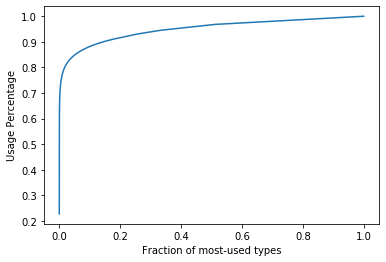

In [16]:
plt.plot(x, cfd)
plt.ylabel("Usage Percentage")
plt.xlabel("Fraction of most-used types")
plt.show()

In [17]:
cfd[10]

0.48993404470785645